<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230529_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data drift에 내성이 있는 학습 방법

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [28]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:

!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 3.58 MiB/s, done.


In [5]:

%cd fr-train
!pwd

/content/fr-train
/content/fr-train


In [6]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

In [7]:

def test_model(model_,model2_, tX, ty, s1):
    model_.eval()
    model2_.eval()

    ax = model2_(tX[:,0:5],tX[:,5].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty.cpu().data.numpy(),y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4].cpu().data.numpy(),columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [8]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output


In [9]:

def test_all_data(generator,adapter,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
            xs = adapter(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(xs)
            predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [10]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):
   
    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""
        
        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        #self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(2, 30))
            self.fc2.append(nn.Linear(30, 1))
            #self.fc3.append(nn.Linear(5, 1))

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1)))
            #h1 = F.relu(self.fc2[i](h0))
            #h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = self.fc2[i](h0)
            h2 = self.fc2[i](h0)
            pxy.append(h2)
            
        return torch.cat(pxy, dim=1)
     

In [29]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    #mine = Net()
    #optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        #loss.backward()
        mi_losses.append(a_loss)
        #optimizer_D_F.step()

        loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator,adapter

# 준비
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

In [12]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [13]:
seed_everything()

y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

40

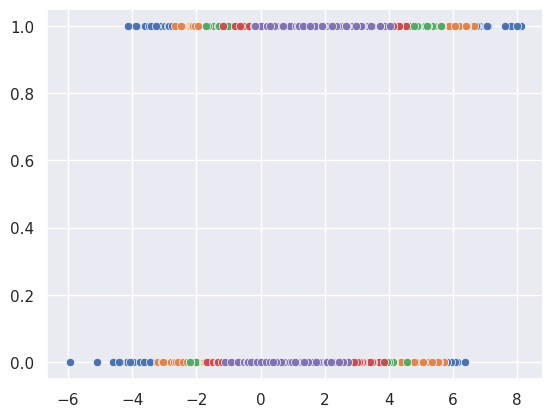

In [14]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

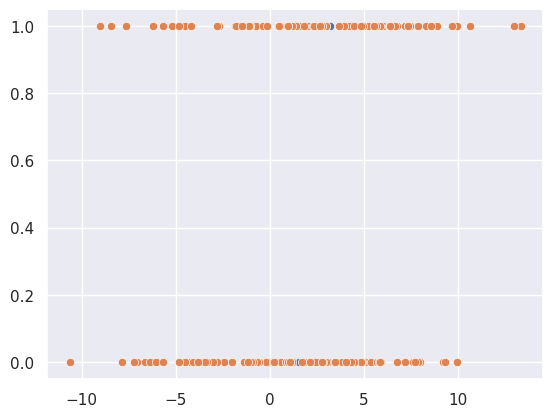

In [15]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## KS-test 통계량의 측정

In [16]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [17]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [18]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


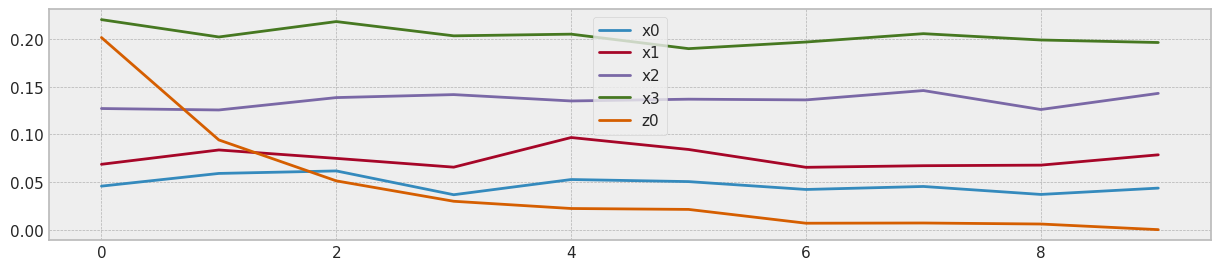

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 42.87it/s]


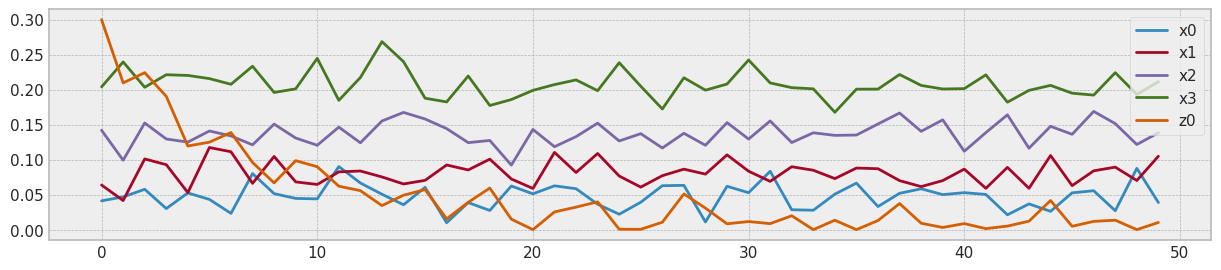

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 70.63it/s]


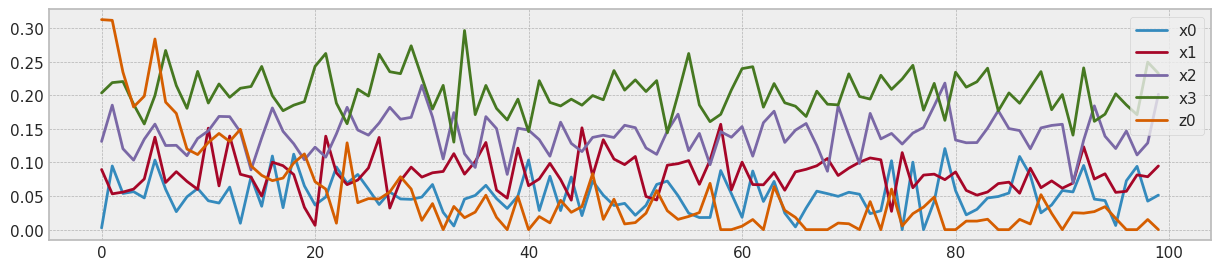

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 99.95it/s] 


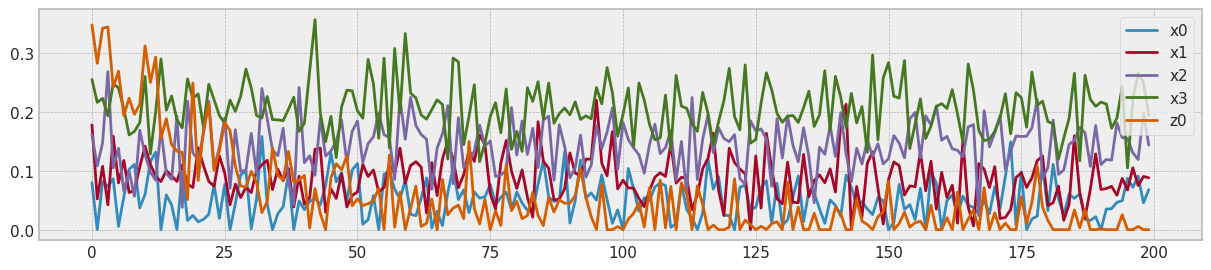

In [19]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

Bucket size 10


100%|██████████| 10/10 [00:00<00:00, 309.99it/s]


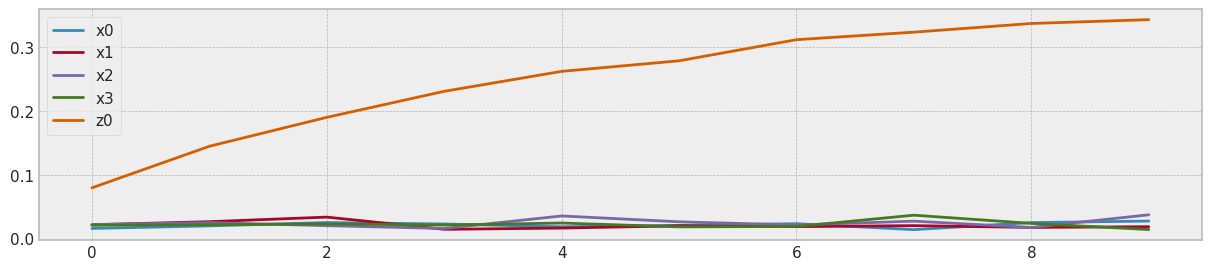

Bucket size 50


100%|██████████| 50/50 [00:00<00:00, 700.23it/s]


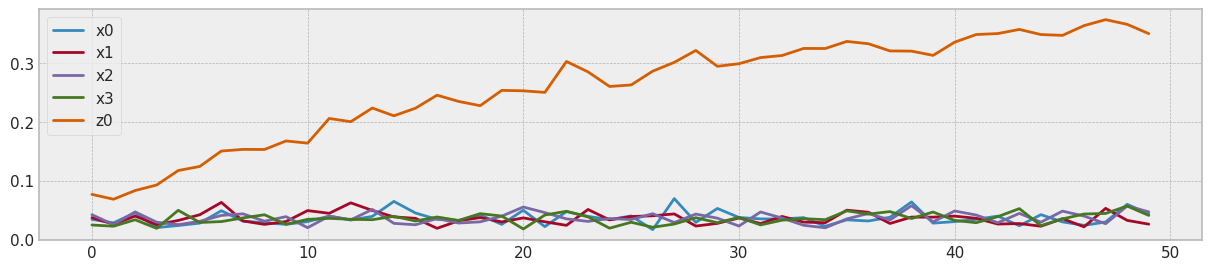

Bucket size 100


100%|██████████| 100/100 [00:00<00:00, 786.10it/s]


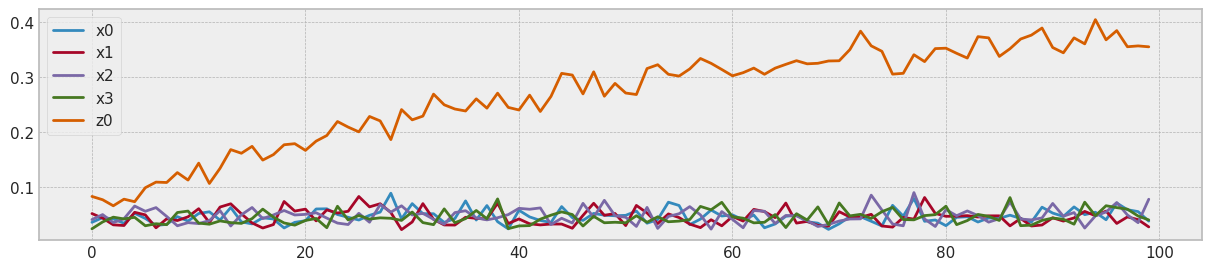

Bucket size 200


100%|██████████| 200/200 [00:00<00:00, 809.00it/s]


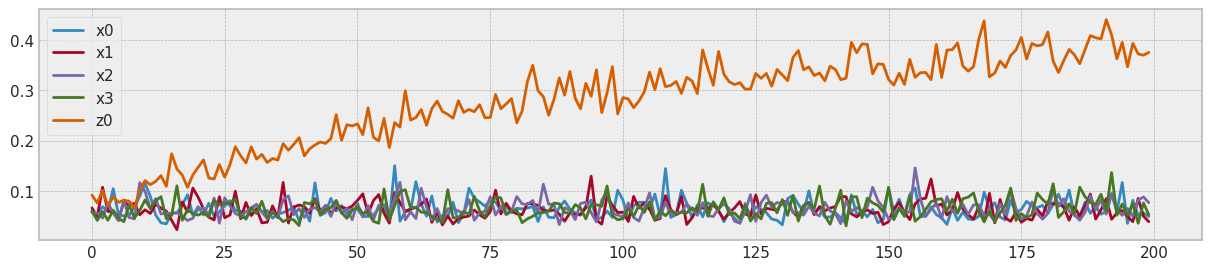

In [20]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X[0:1800].values,X[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

+ 2000개를 학습하고, 이후 38000개를 추정한다.

cuda:0


100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s]


MSE: 0.26
RMSE: 0.51


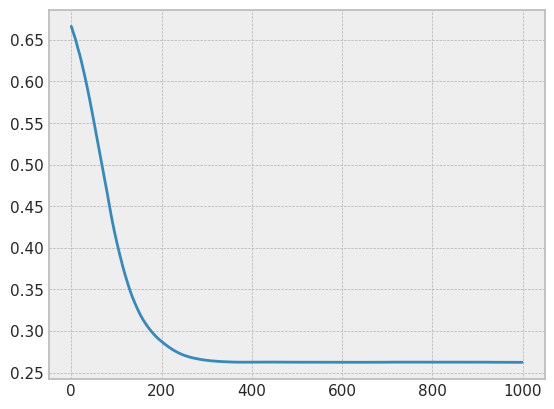

In [31]:
import copy
import torch.optim as optim
 
seed_everything()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32).to(device)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1).to(device)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [22]:
result_table3 = {}
result_table3['lambda']=[]
result_table3['test_f1']=[]
result_table3['init_f1']=[]
result_table3['mean_f1']=[]
result_table3['last_f1']=[]
result_table3['MI(y^,z)']=[]

In [35]:

from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
print('feature 5, test_f1',f1)

feature 5, test_f1 0.8685714285714285


100%|██████████| 189/189 [00:00<00:00, 567.15it/s]


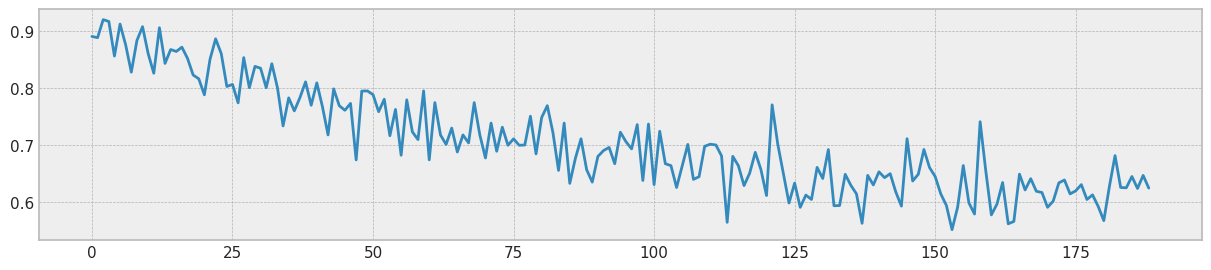

{'lambda': ['Case #1 Feature 5', 'Case #1 Feature 5'], 'test_f1': [0.8685714285714285, 0.8685714285714285], 'init_f1': [0.8899082568807338, 0.8899082568807338], 'mean_f1': [0.7058765598487894, 0.7058765598487894], 'last_f1': [0.6238532110091742, 0.6238532110091742], 'MI(y^,z)': [0.0, 0.0]}


In [36]:

XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32).to(device)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #1 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [37]:
pd.DataFrame(result_table3)

,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Case #1 Feature 5,0.868571,0.889908,0.705877,0.623853,0.0
1,Case #1 Feature 5,0.868571,0.889908,0.705877,0.623853,0.0


## 내성 학습의 적용

In [38]:

# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

,x0,x1,x2,x3,z0,b
0,2.231833,0.663053,2.160447,1.180836,1.125117,0
1,1.326272,2.285045,2.362769,2.638806,2.171340,0
2,1.845348,3.743190,3.310210,1.772473,2.576518,0
3,2.974414,-0.229197,1.024580,1.387895,0.873782,0
4,2.854022,3.102544,1.610779,1.774781,2.490660,0
...,...,...,...,...,...,...
39995,0.085122,-0.571732,1.527233,1.867146,-1.177338,399
39996,1.069521,-0.221247,1.324087,1.798258,4.045168,399
39997,0.429295,2.593988,2.329410,1.859496,1.785665,399
39998,1.611266,-0.588687,-0.591898,2.126287,9.291351,399


cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.019145] [G loss: 0.689915]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.001457] [G loss: 0.684513]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.001348] [G loss: 0.675574]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.002335] [G loss: 0.660182]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.004376] [G loss: 0.639191]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.006877] [G loss: 0.614831]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.009656] [G loss: 0.589124]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.012113] [G loss: 0.563722]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.014013] [G loss: 0.539910]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.014925] [G loss: 0.518391]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.014619] [G loss: 0.499606]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0.013882] [G loss: 0.482686]
[Lambda: 0.4

100%|██████████| 189/189 [00:00<00:00, 347.59it/s]


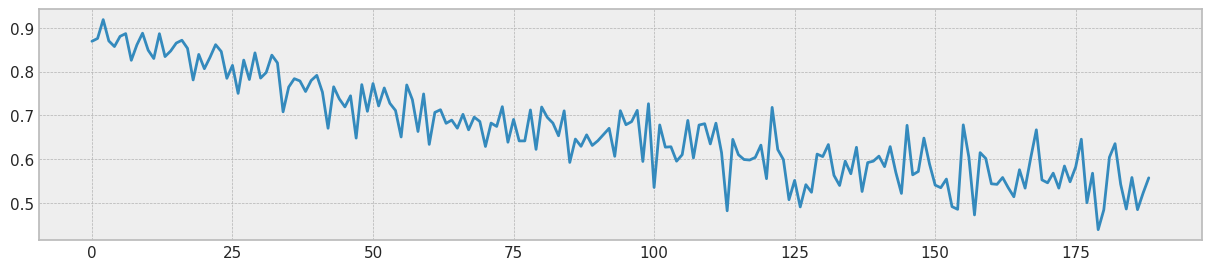

Mean F1 for all data: 0.6666768982894349
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.019098] [G loss: 0.689944]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001313] [G loss: 0.684698]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.000906] [G loss: 0.676162]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.001163] [G loss: 0.661748]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.001951] [G loss: 0.642240]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.003011] [G loss: 0.619431]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.004269] [G loss: 0.595243]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.005601] [G loss: 0.570760]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.006644] [G loss: 0.547367]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.007186] [G loss: 0.525570]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.006958] [G loss: 0.505750]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 345.79it/s]


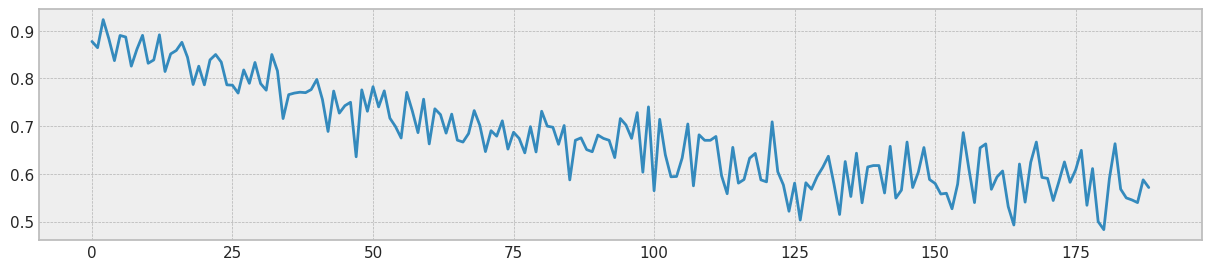

Mean F1 for all data: 0.677821037610782
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.019243] [G loss: 0.689803]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.002468] [G loss: 0.683888]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.004381] [G loss: 0.673488]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.010798] [G loss: 0.654437]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.020651] [G loss: 0.628312]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.029263] [G loss: 0.600760]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.035438] [G loss: 0.574310]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.041599] [G loss: 0.548171]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.046831] [G loss: 0.523636]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.048468] [G loss: 0.502833]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.048495] [G loss: 0.484886]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 0

100%|██████████| 189/189 [00:00<00:00, 346.09it/s]


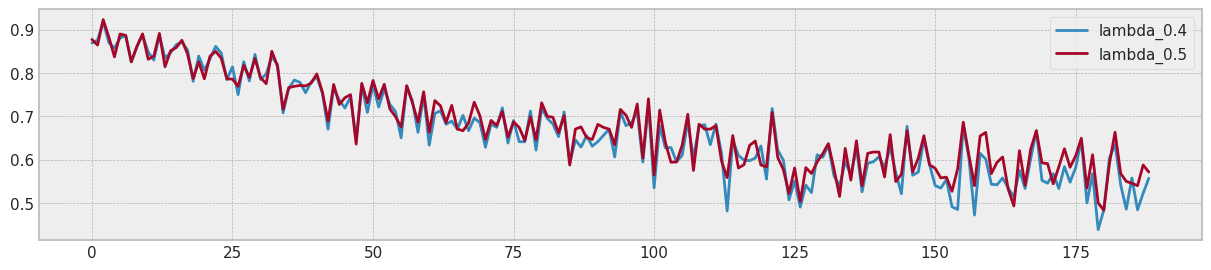

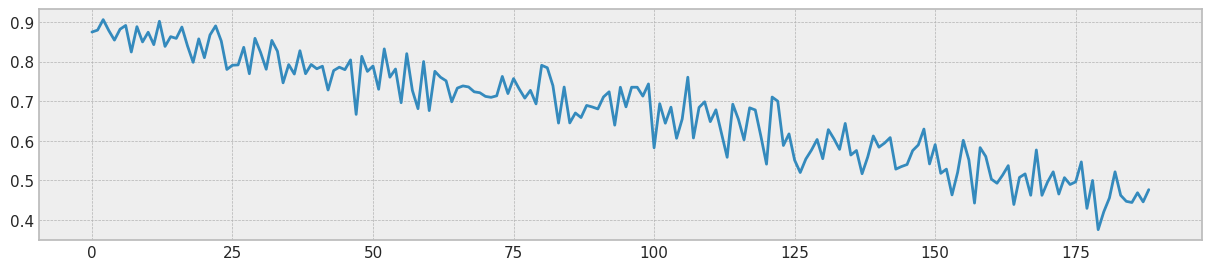

Mean F1 for all data: 0.6742352009598702
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.019186] [G loss: 0.689881]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001717] [G loss: 0.684310]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.002056] [G loss: 0.674933]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.004233] [G loss: 0.658459]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.008309] [G loss: 0.635778]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.012592] [G loss: 0.610114]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.016953] [G loss: 0.583527]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.020747] [G loss: 0.557490]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.023642] [G loss: 0.533432]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.024496] [G loss: 0.512513]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.024075] [G loss: 0.494457]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 344.47it/s]


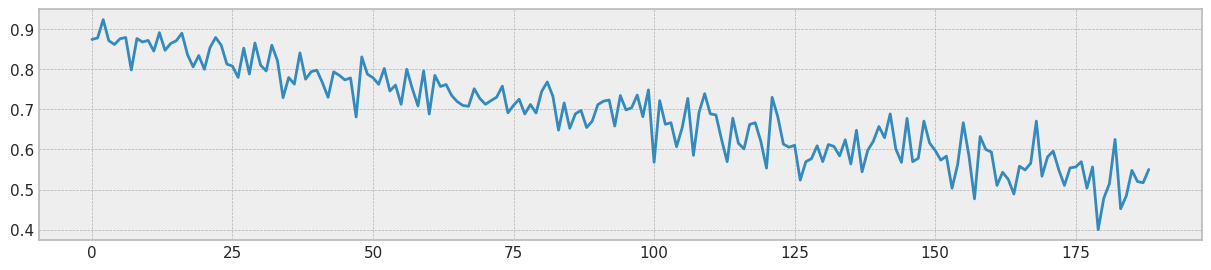

Mean F1 for all data: 0.6887688317603353
cuda:0
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: 0.019091] [G loss: 0.689950]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: 0.001285] [G loss: 0.684737]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: 0.000834] [G loss: 0.676279]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: 0.000990] [G loss: 0.662034]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: 0.001577] [G loss: 0.642831]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: 0.002429] [G loss: 0.620337]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: 0.003451] [G loss: 0.596461]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: 0.004566] [G loss: 0.572238]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: 0.005464] [G loss: 0.548905]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: 0.005915] [G loss: 0.527102]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: 0.005719] [G loss: 0.506962]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 342.69it/s]


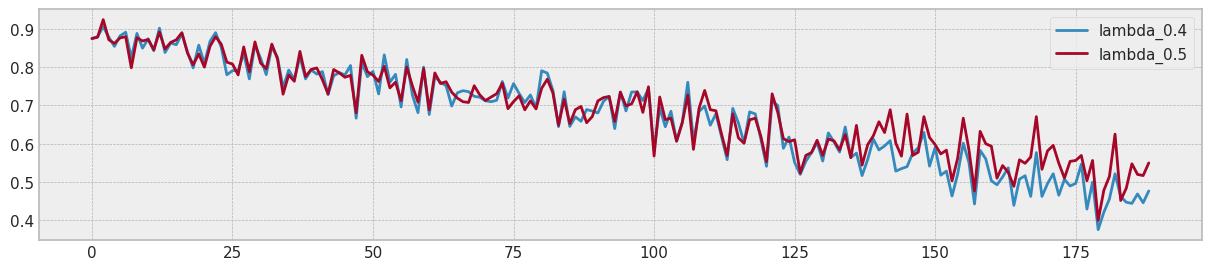

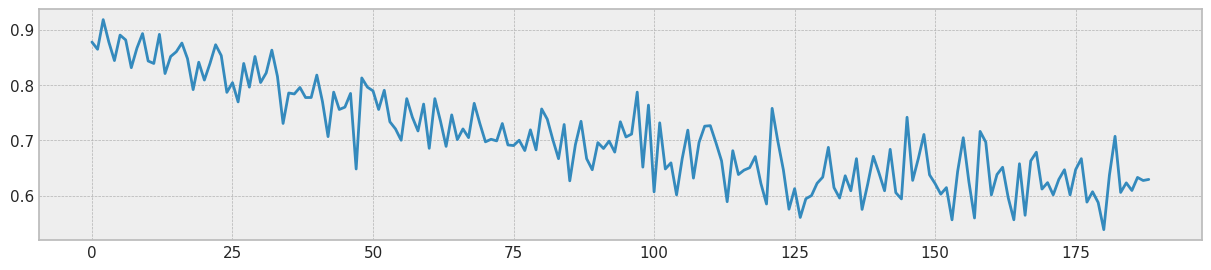

Mean F1 for all data: 0.7064421959807858
cuda:0
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 2.992680] [G loss: 0.693538]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: 0.019062] [G loss: 0.689968]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: 0.001216] [G loss: 0.684851]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: 0.000664] [G loss: 0.676616]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: 0.000600] [G loss: 0.662867]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: 0.000770] [G loss: 0.644514]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: 0.001098] [G loss: 0.622970]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: 0.001549] [G loss: 0.600118]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: 0.002037] [G loss: 0.576876]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: 0.002501] [G loss: 0.553990]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: 0.002723] [G loss: 0.532032]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: 0.002630] [G loss: 0.510973]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: 

100%|██████████| 189/189 [00:00<00:00, 320.57it/s]


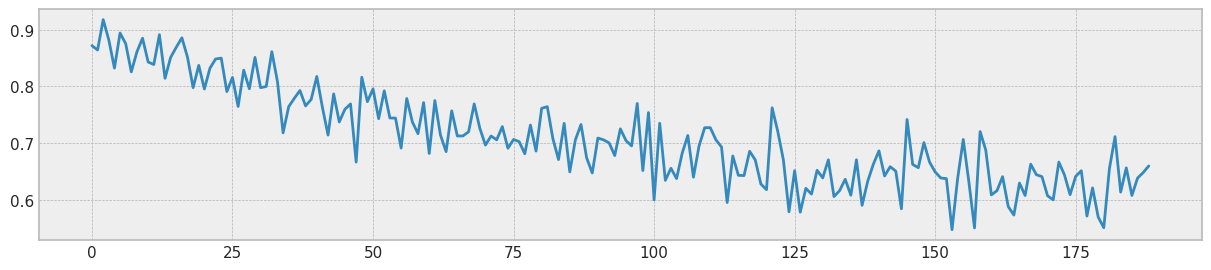

Mean F1 for all data: 0.709910466915569


,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,Case #1 Feature 5,0.868571,0.889908,0.705877,0.623853,0.000000
1,Case #1 Feature 5,0.868571,0.889908,0.705877,0.623853,0.000000
0,0.4,0.875740,0.877358,0.706442,0.629213,0.253611
1,0.5,0.877193,0.872038,0.709910,0.659794,0.244017


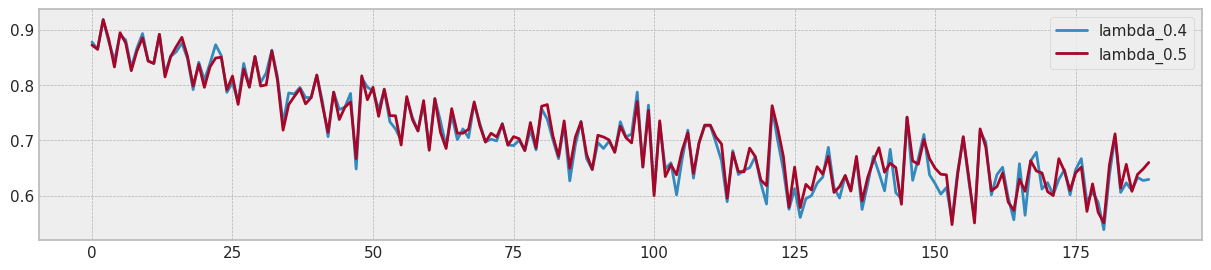

In [48]:
seed_everything()

train_result = []

avaible_range = 400

train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.2, 0.6, 2.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X[2000:][['x0','x1','x2','x3','z0','b']],y[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

In [ ]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [ ]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [ ]:
x1.shape

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4] 
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)
 
plt.plot(y1_array,'.')

In [ ]:
y1 = [1 if y_ > 5 else 0 for y_ in y1_array]

In [ ]:
sum(y1)

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

In [ ]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x1.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X1[bk*step_size:bk*step_size+step_size], y1[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

In [ ]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X1[0:1800].values,X1[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

In [ ]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y1[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y1[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
XT = X1[2000:][['x0','x1','x2','x3','z0']]
yT = y1[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #2 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [ ]:
pd.DataFrame(result_table3)

In [ ]:
X1['b'] = [int(b) for b in X1.index.values]
X1

In [ ]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X1[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y1[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X1[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X1[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y1[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X1[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X1[2000:][['x0','x1','x2','x3','z0','b']],y1[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## synthetic data의 생성 (Case #3 MI의 고정, Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = [] 
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x1[ii]))
 
plt.plot(y2_array,'.')

In [ ]:
y2 = [1 if y_ > 5 else 0 for y_ in y2_array]

In [ ]:
sum(y2)

In [ ]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

In [ ]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x1.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X2[bk*step_size:bk*step_size+step_size], y2[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

In [ ]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int((x.shape[0]-2000)/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)

        ks = __ks_drift(X2[0:1800].values,X2[bk*step_size+2000:bk*step_size+step_size+2000].values)
        #print(ks[:,0])
        for ix,col in enumerate(columns):
            MIS[col].append(ks[:,0][ix]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

## 학습 및 전체 예측

In [ ]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
XT = X2[2000:][['x0','x1','x2','x3','z0']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #3 Feature 5')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [ ]:
pd.DataFrame(result_table3)

## Case #3의 feature 4

In [ ]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y2[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y2[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
XT = X2[2000:][['x0','x1','x2','x3']]
yT = y2[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)-1
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1_ = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
        f1s.append(f1_)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()

result_table3['lambda'].append('Case #3 Feature 4')
result_table3['test_f1'].append(f1)
result_table3['init_f1'].append(f1s[0])
result_table3['mean_f1'].append(np.mean(f1s))
result_table3['last_f1'].append(f1s[-1])
result_table3['MI(y^,z)'].append(mi_scores['z0'])

print(result_table3)

In [ ]:
pd.DataFrame(result_table3)

In [ ]:
X2['b'] = [int(b) for b in X2.index.values]
X2

In [ ]:
seed_everything()

train_result = []

avaible_range = 40000 

train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_tensors1 = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors1 = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#lambda_f_set = [0.4,0.5]
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.



#lambda_f_set2 = [0.0000089,0.0000090,0.0000091] 
lambda_f_set2 = [1.0] 
lambda_a2 = 0.0

for lambda_f2 in lambda_f_set2:
    #lambda_a2 = lambda_f2

    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['MI(y^,z)']=[]

    for lambda_f in lambda_f_set:
        '''
        if lambda_f == 0.0:
            f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
            result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
        else:
        '''
        f1,mi,last_generator, last_adapter = train_model(train_tensors1, test_tensors1, train_opt, lambda_f = lambda_f, seed = seed, alpha= lambda_f2 )# 0.00057)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter,X2[2000:][['x0','x1','x2','x3','z0','b']],y2[2000:])

        result_table2['lambda'].append(lambda_f)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
        result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
        result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
        result_table2['MI(y^,z)'].append(mi)

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=(15,3))
    #plt.show()
    result4_df = pd.DataFrame(result_table2)

    #print(lambda_f2,result4_df)

pd.concat([pd.DataFrame(result_table3),result4_df])

## I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(y^,z) 을 최소화 한다.

In [ ]:
H=20
minibatch = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

In [ ]:

def test_model2(generator_, tX, ty, s1):
    generator_.eval()


    y_hat = generator_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [ ]:

def test_all_data2(generator,XT,yT):

    #XT = X[train_size:][['x0','x1','x2','x3','z0','b']]
    #yT = y[train_size:]
    print('XT.shape',XT.shape)
    bucket_size_array=[200]
    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)-1
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_size:bk*bucket_size+bucket_size].values, dtype=torch.float32)
            #xs = adapter1(tmp_x[:,0:5],tmp_x[:,5].reshape(-1,1)/avaible_range)
            predicted_y = generator(tmp_x[:,0:5])
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_size:bk*bucket_size+bucket_size],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net()
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):



        # -------------------
        #  Forwards Generator
        # -------------------
        gen_y = generator(XS_train[:,0:5]).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
        y2_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret2(y의 샘플)는 maximize 하야 하고
        # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret2 + torch.abs(ret1)

        mi_losses.append(-ret1)

        optimizer_G.zero_grad()
        optimizer_M.zero_grad()

        loss = (1-lambda_f) * g_loss +  lambda_f * mi_loss * alpha #* 0.05

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model2(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [ ]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator = train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data2(last_generator,X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))
#plt.show()
result4_df = pd.DataFrame(result_table2)

#print(lambda_f2,result4_df)


pd.concat([pd.DataFrame(result_table3),result4_df])

## b를 대입하여 b가 작을때는 I(y^,z)을 최대화, b가 커질수록I(y^,z)을 최소화 하도록 학습
+ MINE을 적용, I(G(x,b=0),z) 을 최대화, I(G(x,b=1),z) 을 최소화 한다.

In [ ]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed, alpha):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    s1_train = train_tensors.s1_train.to(device)
    
    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    s1_test = test_tensors.s1_test.to(device)
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    a_losses =[]
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator().to(device)

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    adapter = Sensitivity_Adapter(5).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net().to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.001)

    minibatch = 1000

    for epoch in range(n_epochs):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------
        xs = adapter(XS_train[:,0:5],XS_train[:,5].reshape(-1,1)/avaible_range) # z0, b
        a_loss = torch.sum(mse_loss(xs, XS_train[:,0:5]))
        a_losses.append(a_loss)
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) 
        g_losses.append(g_loss)

        #  Forwards Generator b=1
        gen_y0 = generator(adapter(XS_train[:,0:5],torch.zeros(XS_train.shape[0],1).to(device))).reshape(-1,1)
        gen_y1 = generator(adapter(XS_train[:,0:5], torch.ones(XS_train.shape[0],1).to(device)*0.3)).reshape(-1,1)

        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        x_sample = torch.clone(s1_train[s].reshape(-1,1))
        #Variable(torch.from_numpy(s1_train[s].cpu().data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True).to(device)
        y_sample = gen_y0[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = gen_y0[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    

        y2_sample = gen_y1[s]
        y2_shuffle = gen_y1[np.random.permutation(s)] #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)    

        ret1 = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        ret2 = torch.mean(mine(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y2_shuffle))))

        # ret1(y^(b=0)의 샘플)는 maximize 하야 하고
        # ret2(y^(b=1)의 샘플)는 0으로 minimize 해야 한다.!!! 
        mi_loss = - ret1 + torch.abs(ret2)

        mi_losses.append(-ret2)


        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        loss = (1-lambda_f) * (g_loss + a_loss) + lambda_f * mi_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()            

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [A loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], a_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator,adapter

In [ ]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X2[0:1800][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                          y_train = torch.tensor(y2[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X2[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X2[1800:2000][['x0','x1','x2','x3','z0','b']].values, dtype=torch.float32),
                         y_test = torch.tensor(y2[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X2[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.5] #[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_f_set = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:

    f1,mi,last_generator, last_adapter = train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed,alpha=1.0)
    result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator,last_adapter, X2[2000:][['x0','x1','x2','x3','z0','b']], y2[2000:])

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))
#plt.show()
result4_df = pd.DataFrame(result_table2)

#print(lambda_f2,result4_df)


pd.concat([pd.DataFrame(result_table3),result4_df])